***
***
# **PRELIMINARIES**

***
### **I)** IMPORTS

In [1]:
import matplotlib as mpl 
mpl.rcParams['figure.dpi']=100

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from skimage.io import imread
from skimage.transform import rescale 
from skimage.color import rgb2lab, lab2rgb
from sklearn.metrics.pairwise import euclidean_distances
from skimage.color import rgba2rgb
from mpl_toolkits import mplot3d 

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

import os 
import PIL 
import warnings

warnings.filterwarnings('ignore')

/Users/nannamikkelsen/miniforge3/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


***
### **II)** CHECK TENSORFLOW VERSION AND GPU/CPU

In [2]:
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected!")
    for gpu in gpus:
        print("→", gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU.")
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU detected. Check your CUDA/cuDNN and environment config.")

TensorFlow version: 2.20.0
No GPU detected. Check your CUDA/cuDNN and environment config.


***
***
# **TRAINING DATA**

***
### **III)** INSERT TRAINING DATA
Loads the training data into af panda mainframe. 

In [3]:
train_df = pd.read_csv("emnist-balanced-train.csv", header=None)
print(train_df.head())
print(train_df.describe())
print(train_df.shape)

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   45    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   36    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   43    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
                0         1         2         3         4              5    \
count  112800.00000  112800.0  112800.0  112800.0  112800.0  112800.000000   
mean       23.00000       0.0       0.0       0.0       0.0       0.001365   
std        13.56472       0.0       0.0       0.0       0

***
### **IV)** LABEL DICTIONARY

Creates a dictionary mapping label indice (10-35) to the corresponding letters fro A-Z.

In [4]:
# Read the EMNIST mapping file (maps class labels to ASCII codes)
mapper = pd.read_csv("emnist-balanced-train.csv", sep=',', header=None, index_col=0)
print("mapper shape:", mapper.shape)
print("mapper columns:", mapper.columns)

mapper shape: (112800, 784)
mapper columns: Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       775, 776, 777, 778, 779, 780, 781, 782, 783, 784],
      dtype='int64', length=784)


In [5]:
# Build label dictionary for labels 10..35 from mapping file
label_d = {i: chr(ord('A')+i) for i in range(26)}
print("label_d:", label_d)

label_d: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [6]:
# Sanity-check: ensure all values are printable letters
print({k: v for k, v in label_d.items()})

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


***
### **IV)** PREPROCESSING AND FILTERING TRAINING DATA

In [7]:
train_df_new = train_df[train_df[0].isin(np.arange(10,36))]
train_df_new = train_df_new.reset_index(drop=True)

In [8]:
train_df_new[0] = train_df_new[0] - 10
print(train_df_new.head())
print(train_df_new[0].describe())
print(train_df_new.shape)

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   22    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   10    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
count    62400.00000
mean        12.50000
std          7.50006
min          0.00000
25%          6.00000
50%         12.50000
75%         19.00000
max         25.00000
Name: 0, dtype: float64
(62400, 785)


***
### **V)** SPLIT FEATURES AND LABELS

In [9]:
x_train = train_df_new.loc[:, 1:]
y_train = train_df_new.loc[:, 0]
print(x_train.shape, y_train.shape)

(62400, 784) (62400,)


***
### **VI)** INSPECTING A SAMPLE IMAGE

In [10]:
sample_image = x_train.iloc[1000]
sample_label = y_train.iloc[1000]
print(sample_image.shape, sample_label)

(784,) 5


***
### **VII)** IMAGE PREPROCESSING

In [11]:
def dimension(image):
    W = 28
    H = 28
    image = np.array(image).reshape(W, H)
    return image

def flip_and_rotate(image):
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

***
### **VIII)** VIS. ORIGINAL SAMPLE IMAGE

Label entry No. 1000: F


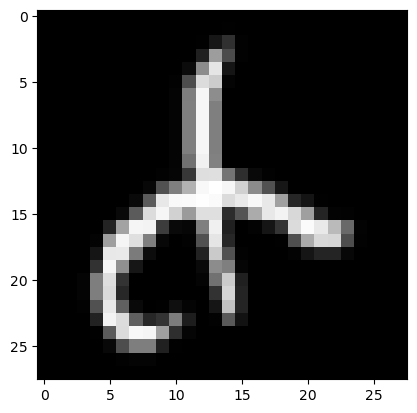

In [12]:
print("Label entry No. 1000:", label_d[sample_label])
plt.imshow(dimension(sample_image), cmap=plt.cm.gray)
plt.show()

***
### **IX)** VIS. PREPROCESSED SAMPLE IMAGE

Label entry 1000: F


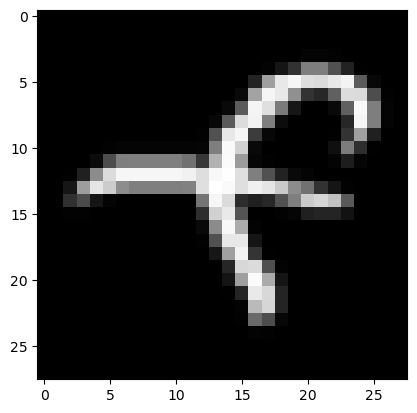

In [13]:
print("Label entry 1000:", label_d[sample_label])
plt.imshow(flip_and_rotate(dimension(sample_image)), cmap=plt.cm.gray)
plt.show()

*** 
### **X)** RESHAPE TRAINING IMAGES

In [14]:
x_train = np.apply_along_axis(dimension, 1, x_train)
print(x_train.shape)

(62400, 28, 28)


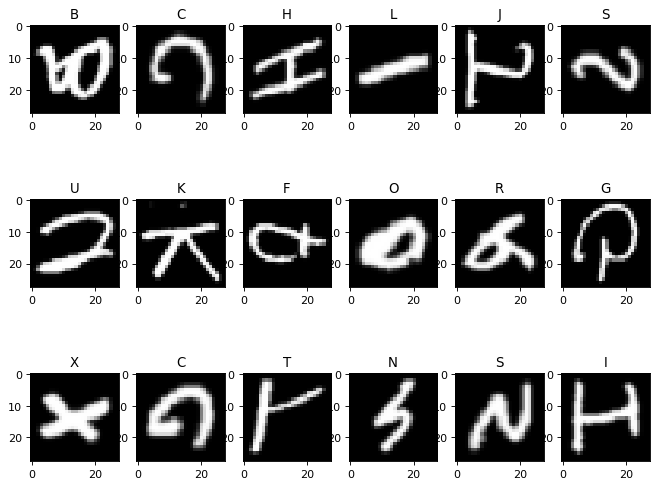

In [15]:
plt.figure(figsize=(10, 8), dpi=80)
for i in range(100, 118):
    plt.subplot(3, 6, i-99)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label_d[y_train[i]])
plt.show()

*** 
### **XI)** APPLY FLIP AND ROTATE TO PREPROCESSED TRAINING IMAGES

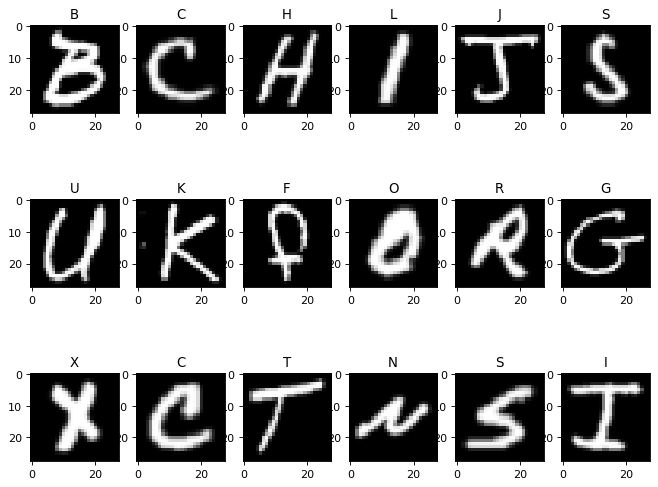

In [16]:
x_train = np.array([flip_and_rotate(img) for img in x_train])

plt.figure(figsize=(10, 8), dpi=80)
for i in range(100, 118):
    plt.subplot(3, 6, i-99)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label_d[y_train[i]])
plt.show()

***
***
# **TEST DATA**

In [17]:
test_df = pd.read_csv("emnist-balanced-test.csv", header=None)
print(test_df.head())
print(test_df.describe())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   41    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   39    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   26    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   44    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
                0        1        2        3        4             5    \
count  18800.000000  18800.0  18800.0  18800.0  18800.0  18800.000000   
mean      23.000000      0.0      0.0      0.0      0.0      0.006064   
std       13.565021      0.0      0.0      0.0      0.0      0.528828   

In [18]:
test_df_new = test_df[test_df[0].isin(np.arange(10, 36))]
test_df_new = test_df_new.reset_index(drop=True)
test_df_new[0] = test_df_new[0] - 10
print(test_df_new.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    2    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [19]:
x_test = test_df_new.loc[:, 1:]
y_test = test_df_new.loc[:, 0]
x_test = np.array([dimension(img) for img in x_test.to_numpy()])
x_test = np.array([flip_and_rotate(img) for img in x_test])
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_test: (10400, 28, 28)
y_test: (10400,)


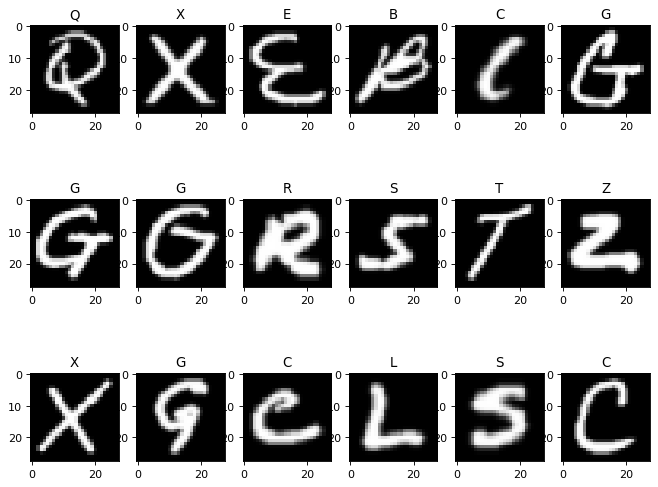

In [20]:
plt.figure(figsize=(10, 8), dpi=80)
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(x_test[i], cmap=plt.cm.gray)
    plt.title(label_d[y_test.iloc[i]])
plt.show()

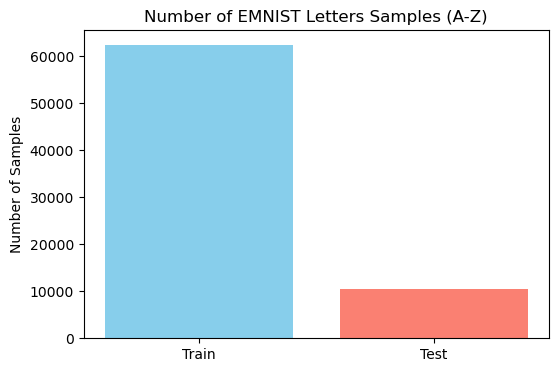

In [21]:
plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Test'], [y_train.shape[0], y_test.shape[0]], 
        color=['skyblue', 'salmon'])
plt.title('Number of EMNIST Letters Samples (A-Z)')
plt.ylabel('Number of Samples')
plt.show()

In [22]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [23]:
number_of_classes = y_train.nunique()
print(number_of_classes)

26


In [24]:
W = 28
H = 28
x_train_cnn = x_train.reshape(-1, W, H, 1)
x_test_cnn = x_test.reshape(-1, W, H, 1)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(x_train_flat.shape)
print(x_test_flat.shape)

(62400, 28, 28, 1)
(10400, 28, 28, 1)
(62400, 784)
(10400, 784)


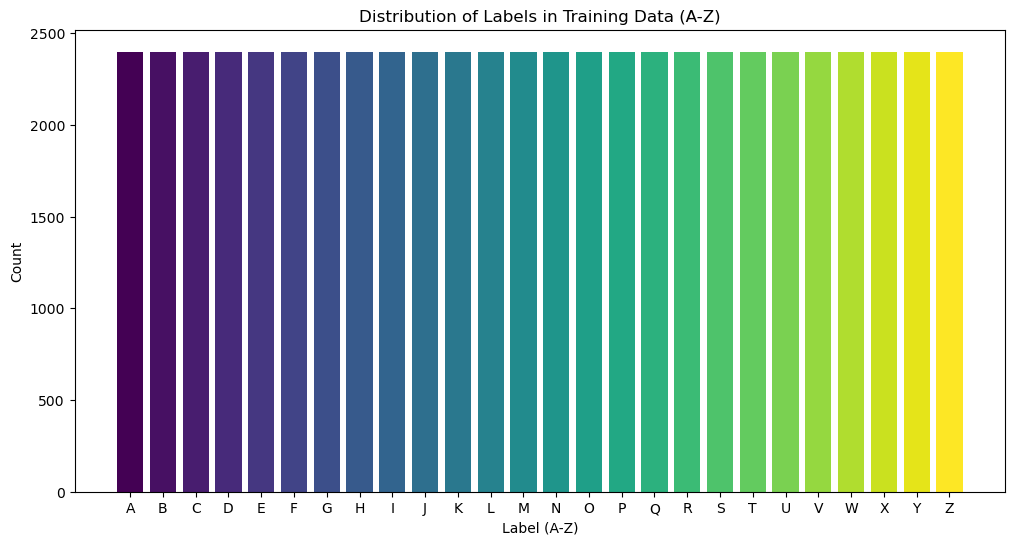

In [25]:
unique_labels, counts = np.unique(y_train, return_counts=True)
letter_labels = [label_d[label] for label in unique_labels]
plt.figure(figsize=(12, 6))
plt.bar(letter_labels, counts, color=plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_labels))))
plt.xlabel("Label (A-Z)")
plt.ylabel("Count")
plt.title("Distribution of Labels in Training Data (A-Z)")
plt.show()

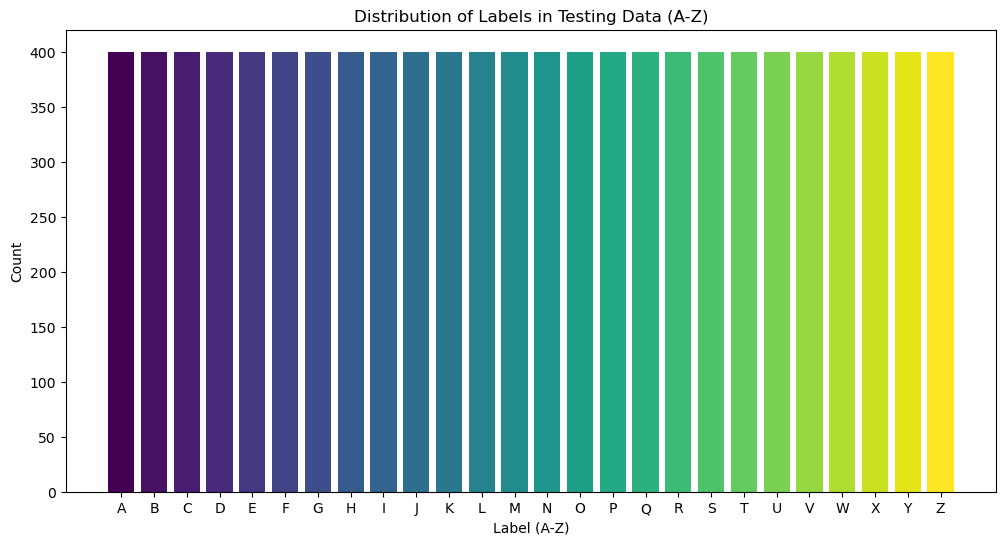

In [26]:
unique_labels, counts = np.unique(y_test, return_counts=True)
letter_labels = [label_d[label] for label in unique_labels]
plt.figure(figsize=(12, 6))
plt.bar(letter_labels, counts, color=plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_labels))))
plt.xlabel("Label (A-Z)")
plt.ylabel("Count")
plt.title("Distribution of Labels in Testing Data (A-Z)")
plt.show()

In [27]:
nn_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax')
])

In [28]:
nn_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [29]:
history_nn = nn_model.fit(x_train_flat, y_train, epochs=10, batch_size=32,
                          validation_data=(x_test_flat, y_test))

Epoch 1/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7961 - loss: 0.7008 - val_accuracy: 0.8720 - val_loss: 0.4238
Epoch 2/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8912 - loss: 0.3514 - val_accuracy: 0.8897 - val_loss: 0.3606
Epoch 3/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9110 - loss: 0.2789 - val_accuracy: 0.8953 - val_loss: 0.3267
Epoch 4/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9217 - loss: 0.2383 - val_accuracy: 0.9098 - val_loss: 0.2990
Epoch 5/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9292 - loss: 0.2100 - val_accuracy: 0.9128 - val_loss: 0.2895
Epoch 6/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9374 - loss: 0.1853 - val_accuracy: 0.9116 - val_loss: 0.3037
Epoch 7/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9422 - loss: 0.1684 - val_accuracy: 0.9137 - val_loss: 0.2934
Epoch 8/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9460 - loss: 0.1543 - 

In [30]:
loss_nn, accuracy_nn = nn_model.evaluate(x_test_flat, y_test)
print(f"Neural Network Model Accuracy on Test Set: {accuracy_nn}")

325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.9144 - loss: 0.3080
Neural Network Model Accuracy on Test Set: 0.9144230484962463


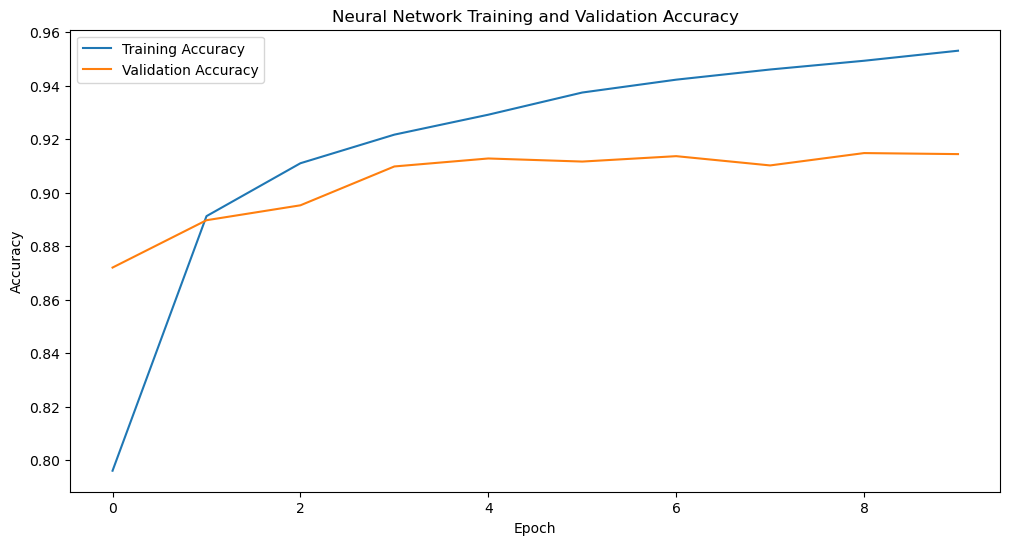

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(history_nn.history['accuracy'], label='Training Accuracy')
plt.plot(history_nn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Neural Network Training and Validation Accuracy')
plt.legend()
plt.show()

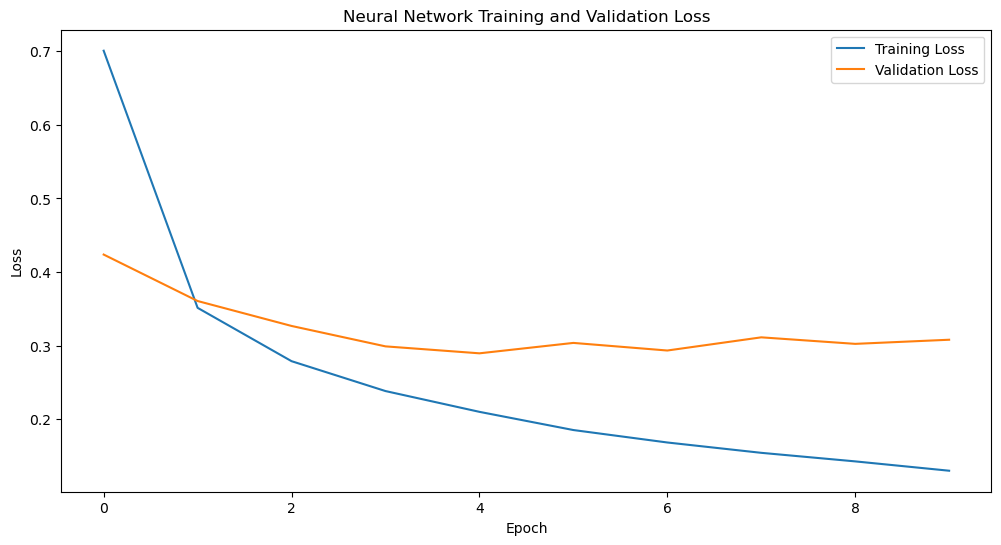

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history_nn.history['loss'], label='Training Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training and Validation Loss')
plt.legend()
plt.show()